<a href="https://colab.research.google.com/github/tsugumasa320/VAE_Study/blob/main/pytorch_lightning_AE4Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pystyle.info/pytorch-lightning-auto-encoder-train-mnist/
参考

#課題

    済・データセットを自作のものに置き換え
    済・STFTして実部と虚部に分けて、実部をモデルに入力する
    ・DataLoaderの動きの理解とデバッグ
    ・データの入力方法を洗練させる（Mel STFTする)
    ・モデルをVAEに改造
    ・オプティマイザー再度確認
    ・ラベルを読み込む
    ・ラベルを使って操作をする

#1.必要なライブラリやモジュールの準備


In [160]:
! pip install --quiet pytorch_lightning

In [161]:
from pathlib import Path
from typing import Optional, Union, Tuple # 型ヒント
from torch.utils.data import DataLoader, Dataset #追加

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision # 不要になるかも
import torchaudio
import gdown
#追加
import torchaudio.transforms as T

In [162]:
# @title Prepare data and utility functions. {display-mode: "form"}
# @markdown
# @markdown You do not need to look into this cell.
# @markdown Just execute once and you are good to go.

# -------------------------------------------------------------------------------
# Preparation of data and helper functions.
# -------------------------------------------------------------------------------
import multiprocessing
import os

import matplotlib.pyplot as plt
from IPython.display import Audio, display


_SAMPLE_DIR = "_assets"
DATASET_PATH = os.path.join(_SAMPLE_DIR, "dataset")
os.makedirs(DATASET_PATH, exist_ok=True)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [163]:
#Datasetダウンロードとunzip
gdown.download('https://drive.google.com/uc?id=1keOTwrdNqkFWFXQ0kQ5x8obp-prSolRj', 'nsynth-subset.zip' , quiet=True) #全部で２２個のファイル
!unzip -q nsynth-subset
#当該フォルダに保存できたか確認
wavepath = list(Path("nsynth-subset").glob("**/*.wav"))
print(wavepath[:2])

replace nsynth-subset/vocal_acoustic_000-056-025.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
[PosixPath('nsynth-subset/vocal_acoustic_000-052-127.wav'), PosixPath('nsynth-subset/vocal_acoustic_000-070-075.wav')]


16000


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


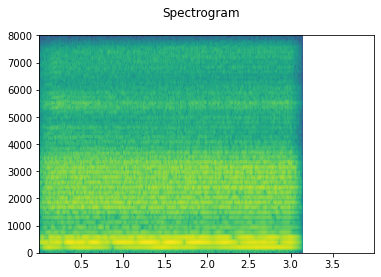

In [164]:
#Datasetの音源再生
waveform, sample_rate = torchaudio.load(wavepath[4])
print(sample_rate)
play_audio(waveform, sample_rate)
plot_specgram(waveform,sample_rate)

#2. Datasetクラスの作成

In [242]:
x = torch.randn(1,64000)
print(x.shape)
x = x[:,:32000]
print(x.shape)

torch.Size([1, 64000])
torch.Size([1, 32000])
tensor([[ 1.1565,  0.3392, -0.2297,  ...,  2.7169, -0.2007,  1.7009]])


In [360]:
class NsynthSubset(torch.utils.data.Dataset): #YESNO Dataseを参考にした
    def __init__(self, dir_path="nsynth-subset"):
        super().__init__()
        self.dir_path = dir_path
        self.wave_paths = [str(p) for p in Path(self.dir_path).glob("**/*.wav")]       

    def __len__(self):
        return len(self.wave_paths)

    def __getitem__(self, idx: int):
        #入力
        waveform, sample_rate = torchaudio.load(self.wave_paths[idx])
        waveform = waveform[:,:32000]
        #STFT
        N_FFT=1024
        HOP_LENGTH=256

        #普通のSTFTにするとエラー多発. 型関連でおかしくなっていた模様
        #山本さんのを見て同じようにメルスペクトログラムにしたらすんなり行ったが原因がわからない
        stft = T.MelSpectrogram(n_fft=N_FFT,
                            hop_length=HOP_LENGTH,
                            )
        specgram  = stft(waveform)
        #specgram =torchaudio.transforms.AmplitudeToDB(specgram)
        #magunitude = torch.abs(specgram) # magunitude = √Re(x)^2 + Im(x)^2
        #phase = torch.angle(specgram) # phase = arctan( Im(x) / Re(x) )

        #ラベル
        #label = self.label[idx]
        #label = 0

        return specgram #magunitude, sample_rate, label, phase
       

In [361]:
dataset = NsynthSubset()
dataloader = DataLoader(dataset, batch_size=3)

for batch in dataloader:
    print(batch.shape)
    print(batch.dtype)

torch.Size([3, 1, 128, 126])
torch.float32
torch.Size([3, 1, 128, 126])
torch.float32
torch.Size([3, 1, 128, 126])
torch.float32
torch.Size([3, 1, 128, 126])
torch.float32
torch.Size([3, 1, 128, 126])
torch.float32
torch.Size([3, 1, 128, 126])
torch.float32
torch.Size([3, 1, 128, 126])
torch.float32
torch.Size([1, 1, 128, 126])
torch.float32


In [310]:
dataset = NsynthSubset()
print(dataset[2])
print(dataset[2].dtype)

tensor([[[ 2.1505e-02+0.0000e+00j,  2.5364e-02+0.0000e+00j,
           3.9338e-03+0.0000e+00j,  ...,
          -9.6929e-03+0.0000e+00j,  2.6806e-03+0.0000e+00j,
          -3.2796e-03+0.0000e+00j],
         [-5.2092e-03+5.5401e-10j, -3.9475e-03-2.2807e-03j,
          -5.3799e-03-8.8581e-03j,  ...,
           6.5710e-03+2.6977e-03j,  2.0224e-03+4.5221e-03j,
          -6.2124e-03-1.8372e-05j],
         [-5.9078e-03+7.3868e-10j,  1.3741e-02+5.3429e-04j,
          -3.7147e-03+3.2738e-03j,  ...,
          -1.3293e-02+8.9136e-05j,  1.1753e-02+4.2631e-03j,
          -4.7274e-03-2.0545e-05j],
         ...,
         [-9.0040e-06-7.3868e-10j, -1.4275e-04-2.5248e-06j,
           2.3242e-04+3.5037e-06j,  ...,
          -1.8926e-05-1.3525e-05j,  5.8721e-04-6.6614e-06j,
          -9.4721e-04+1.1585e-05j],
         [-1.0543e-05-1.2927e-09j, -1.5273e-04+6.9621e-06j,
           2.4527e-04+5.0673e-07j,  ...,
          -1.6467e-05-1.5775e-06j,  1.2354e-04+4.6698e-04j,
           7.8571e-04-4.7918e-06j],
 

ISTFTして確かめてみるかい

In [319]:
from torchvision.transforms.transforms import ToTensor
# LightningDataModuleはDataLoader(場合によってはDatasetも)となるクラス

class NsynthDataModule(pl.LightningDataModule):    

    def __init__(self, batch_size, data_dir="./"):
        super().__init__() #親クラスのinit

        dataset = NsynthSubset()
        num_train = 15 #trainの数
        num_val = 7 #valの数

        self.train_dataset, self.val_dataset = torch.utils.data.random_split( #trainとvalを分ける
            dataset, [num_train, num_val]
        )
 #       self.train_datase = torch.tensor(train_dataset)
 #       self.val_dataset = torch.tensor(val_dataset)

        self.test_dataset = NsynthSubset()
  #      self.test_dataset = torch.tensor(test_dataset)

#        for i in range(num_train):
#            self.train_dataset = train_dataset[i][0][:,:,:] #4秒で切り捨て(8000[sr]*4[s]). これで大丈夫か？
#        for j in range(num_val):
#            self.val_dataset = val_dataset[j][0][:,:,:]
#            self.test_dataset = test_dataset[j][0][:,:,:]

        self.batch_size = batch_size
        self.data_dir = data_dir

    def train_dataloader(self): # Train用DataLoaderの設定
        return torch.utils.data.DataLoader(
            self.train_dataset, batch_size=self.batch_size, num_workers=8
        )

    def val_dataloader(self): # val用DataLoaderの設定
        return torch.utils.data.DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=8
        )

    def test_dataloader(self): # Test用DataLoaderの設定
        return torch.utils.data.DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=8
        )

    def predict_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=8
        )

a = NsynthDataModule(batch_size=32)
b=a.train_dataset
#print(b.shape)

#for data in a.train_dataloader():
#    print(data)
#    break
#print(data)

3. LightningModule を作成する

LightningModule にモデルや各処理を定義します。 モデルの構造ですが、

1.   784次元の入力層

2.   64次元の全結合層

3.   ReLU

4.   32次元の全結合層

5.   64次元の全結合層

6.   ReLU

7.   784次元の全結合層

となっており、入力画像と同じ画像を出力することが学習の目標なの

で、入力画像と出力画像の差異を mse_loss() で計算します。



In [363]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, hidden_dim=64): #Define computations here
        super().__init__()
        self.encoder = nn.Sequential( # encoder設定(784,64,32)
            nn.Linear(126, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 32)
        )
        self.decoder = nn.Sequential(# decoder設定(32,64,784)
            nn.Linear(32, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 126)
        )
        self.transform = torchvision.transforms.ToTensor() #not use

    def forward(self, x): # Use for inference only (separate from training_step)
        #print(x.dtype)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def training_step(self, batch, batch_idx): # the complete training loop
        return self._common_step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx): # the complete validation loop
        self._common_step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx): # the complete test loop
        self._common_step(batch, batch_idx, "test")

    def predict_step(self, batch, batch_idx, dataloader_idx=None): # the complete prediction loop
        x, _ = batch
        return self(x)

    def configure_optimizers(self): #Optimizerと学習率(lr)設定
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def _prepare_batch(self, batch): #batch準備
        x = batch #x, _ = batch
        return x #x.view(x.size(0), -1)

    def _common_step(self, batch, batch_idx, stage): #ロス関数定義
        x = self._prepare_batch(batch)
        loss = F.mse_loss(x, self(x)) #　mse_loss(input, target) self(x)はpredict_stepで定義
        self.log(f"{stage}_loss", loss, on_step=True)
        return loss

In [365]:
class MyPrintingCallback(pl.callbacks.Callback):
    def __init__(
        self, output_dir: str = "./generated", num_samples: int = 64, nrow: int = 8
    ):
        super().__init__()
        self.num_samples = num_samples

    def on_train_start(self, trainer, pl_module):
        print("Training is starting")

    def on_train_end(self, trainer: pl.Trainer, model: pl.LightningModule) -> None:
        # 生成する枚数をバッチサイズに指定し、検証用のデータセットから取得する。
        dataloader = torch.utils.data.DataLoader(
            trainer.datamodule.val_dataset, batch_size=self.num_samples
        )
        img_in = next(iter(dataloader))

        with torch.no_grad():
            model.eval()
            wav_out = model(img_in.to(model.device))
            model.train()
        #istftするコードを書く必要あり
        #print(wav_out)
        #print(wav_out.shape)
        #play_audio(wav_out, 8000)
        print("Training is ending")

5. Trainer を作成して、学習する

In [368]:
dm = NsynthDataModule(batch_size=32, data_dir="./")
model = LitAutoEncoder()

trainer = pl.Trainer(
    max_epochs=10, log_every_n_steps=1, gpus=None, callbacks=[MyPrintingCallback()]
)

trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 10.2 K
1 | decoder | Sequential | 10.3 K
---------------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training is starting


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training is ending


Auto Encoder で次元削減
学習した Auto Encoder の Encoder で抽出した特徴量を使って、学習してみます。

学習した Auto Encoder の Encoder で (784,) -> (32,) に次元削減する

SVM で学習する

精度を計算する

In [ ]:
def extract(dataloader):
    X, y = [], []
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.view(x_batch.size(0), -1)
        feat = model.encoder(x_batch)

        X.append(feat)
        y.append(y_batch)

    X = torch.concat(X).detach().numpy()
    y = torch.concat(y).detach().numpy()

    return X, y


# 学習データ、テストデータを Encoder で特徴量に変換する
X_train, y_train = extract(dm.train_dataloader())
X_test, y_test = extract(dm.test_dataloader())

In [ ]:
from sklearn import metrics, svm

clf = svm.SVC(kernel="linear", C=1, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print(f"accuracy: {acc:.2%}")